In [1]:
import os
os.chdir(r'/home/fruitspec-lab/FruitSpec/Code/roi/fsCounter')
from MHS.F_model_training import *
from math import radians, cos, sin, asin, sqrt
from vision.misc.help_func import go_up_n_levels

os.chdir(r'/home/fruitspec-lab/FruitSpec/Code/roi/fsCounter/MHS')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/home/fruitspec-lab/anaconda3/envs/FsCounterGPUtest/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
def distance(lat1, lat2, lon1, lon2):
    # convert from degrees to radians
    lon1 = radians(lon1)
    lon2 = radians(lon2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2

    c = 2 * asin(sqrt(a))

    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371

    # calculate the result
    return (c * r) * 1000  # results in M

def get_row_length(df_jz):
    try:
        if isinstance(df_jz, str):
            df_jz = pd.read_csv(df_jz)
        df_merged = df_jz
        df_merged = df_merged.fillna(method='bfill')

        if df_merged is None: # None where is no overlap between GPS and JZ
            return 0
        first_index = min(df_merged.index)
        last_index = max(df_merged.index)
        lat1 = float(df_merged.latitude[first_index])
        lat2 = float(df_merged.latitude[last_index])
        lon1 = float(df_merged.longitude[first_index])
        lon2 = float(df_merged.longitude[last_index])

        return distance(lat1, lat2, lon1, lon2)
    except:
        return 0


def get_valid_row_paths(master_folder):
    paths_list = []
    for root, dirs, files in os.walk(master_folder):
        if np.all([file in files for file in ["jaized_timestamps.csv"]]):
            row_scan_path = os.path.abspath(root)
            paths_list.append(os.path.join(row_scan_path, "jaized_timestamps.csv"))
    return paths_list

def get_full_name_from_path(path_to_row_jz):
    customer_name = os.path.basename(go_up_n_levels(path_to_row_jz,5))
    block_name = os.path.basename(go_up_n_levels(path_to_row_jz,4))
    row_name = "R" + os.path.basename(go_up_n_levels(path_to_row_jz,2)).split("_")[-1]
    scan_name = "S" + os.path.basename(go_up_n_levels(path_to_row_jz,1)).split("_")[-1]
    full_name = f"{customer_name}_{block_name}_{row_name}_{scan_name}"
    return full_name

def run_on_folder(master_folder, njobs=1):
    paths_list = get_valid_row_paths(master_folder)
    n = len(paths_list)
    if njobs > 1:
        with ProcessPoolExecutor(max_workers=njobs) as executor:
            res = list(executor.map(get_row_length, paths_list))
    else:
        res = list(map(get_row_length, paths_list))
    res_names = list(map(get_full_name_from_path, paths_list))
    return dict(zip(res_names, res))

        
master_folder = "/media/fruitspec-lab/cam175/FOWLER"
row_lengths = run_on_folder(master_folder)


row_lengths

{'FOWLER_BLOCKAT0_R10_S1': 383.93036172078627,
 'FOWLER_BLOCKAT0_R11_S1': 368.5805847745104,
 'FOWLER_BLOCKAT0_R12_S1': 384.93463295742293,
 'FOWLER_BLOCKAT0_R13_S1': 385.0239814500981,
 'FOWLER_BLOCKAT0_R14_S1': 385.2761415943326,
 'FOWLER_BLOCKAT0_R15_S1': 385.38666025177037,
 'FOWLER_BLOCKAT0_R4_S1': 0,
 'FOWLER_BLOCKAT0_R5_S1': 376.32606691804114,
 'FOWLER_BLOCKAT0_R6_S1': 383.3665475837488,
 'FOWLER_BLOCKAT0_R7_S1': 385.4837590410341,
 'FOWLER_BLOCKAT0_R8_S1': 383.74820046342796,
 'FOWLER_BLOCKAT0_R9_S1': 384.2066547088208,
 'FOWLER_BLOCKAX0_R1_S1': 382.5724465082087,
 'FOWLER_BLOCKAX0_R10_S1': 379.7954542691559,
 'FOWLER_BLOCKAX0_R11_S1': 0,
 'FOWLER_BLOCKAX0_R12_S1': 367.8815101790299,
 'FOWLER_BLOCKAX0_R13_S1': 0,
 'FOWLER_BLOCKAX0_R14_S1': 282.3153347617575,
 'FOWLER_BLOCKAX0_R15_S1': 44.08832976491938,
 'FOWLER_BLOCKAX0_R2_S1': 0,
 'FOWLER_BLOCKAX0_R4_S1': 380.38084233482704,
 'FOWLER_BLOCKAX0_R5_S1': 382.35401441635497,
 'FOWLER_BLOCKAX0_R6_S1': 0,
 'FOWLER_BLOCKAX0_R7_S1': 

In [3]:
def get_valid_row_paths_n_tracks(master_folder):
    paths_list = []
    for root, dirs, files in os.walk(master_folder):
        if np.all([file in files for file in ["tracks.csv"]]):
            row_scan_path = os.path.abspath(root)
            paths_list.append(os.path.join(row_scan_path, "tracks.csv"))
    return paths_list

def get_n_tracks(tracks_path):
    df_tracks = pd.read_csv(tracks_path)
    uniq, counts = np.unique(df_tracks["track_id"], return_counts=True)
    return len(uniq), len(uniq[counts>1]), len(uniq[counts>2])

def run_on_folder_tracks(master_folder, njobs=1):
    paths_list = get_valid_row_paths_n_tracks(master_folder)
    n = len(paths_list)
    if njobs > 1:
        with ProcessPoolExecutor(max_workers=njobs) as executor:
            res = list(executor.map(get_n_tracks, paths_list))
    else:
        res = list(map(get_n_tracks, paths_list))
    res_names = list(map(get_full_name_from_path, paths_list))
    return dict(zip(res_names, res))

        
master_folder = "/media/fruitspec-lab/cam175/FOWLER"
n_tracks = run_on_folder_tracks(master_folder)


n_tracks

{'FOWLER_BLOCKAT0_R10_S1': (92476, 66240, 54389),
 'FOWLER_BLOCKAT0_R11_S1': (109091, 79816, 65738),
 'FOWLER_BLOCKAT0_R12_S1': (75296, 53445, 44082),
 'FOWLER_BLOCKAT0_R13_S1': (92911, 65888, 53473),
 'FOWLER_BLOCKAT0_R14_S1': (69177, 47779, 38930),
 'FOWLER_BLOCKAT0_R15_S1': (93630, 65093, 52129),
 'FOWLER_BLOCKAT0_R4_S1': (72925, 53252, 44602),
 'FOWLER_BLOCKAX0_R1_S1': (30743, 20740, 17374),
 'FOWLER_BLOCKAX0_R10_S1': (20406, 13254, 10841),
 'FOWLER_BLOCKAX0_R11_S1': (27277, 19169, 16306),
 'FOWLER_BLOCKAX0_R12_S1': (22619, 15224, 12472),
 'FOWLER_BLOCKAX0_R14_S1': (12662, 8478, 7004),
 'FOWLER_BLOCKAX0_R15_S1': (1915, 1355, 1121),
 'FOWLER_BLOCKAX0_R4_S1': (25211, 16938, 14198),
 'FOWLER_BLOCKAX0_R5_S1': (26655, 17504, 14281),
 'FOWLER_BLOCKAX0_R7_S1': (2, 0, 0),
 'FOWLER_BLOCKAX0_R8_S1': (19974, 13178, 10950),
 'FOWLER_BLOCKBT0_R1_S1': (9281, 5590, 4071),
 'FOWLER_BLOCKBT0_R10_S1': (91215, 58783, 43897),
 'FOWLER_BLOCKBT0_R12_S1': (76380, 48380, 36667),
 'FOWLER_BLOCKBT0_R13_S1':

In [4]:
df_out = pd.DataFrame(n_tracks).T
df_out.columns = ["cv1", "cv2", "cv3"]
df_out["row_len"] = df_out.index.map(row_lengths)
for i in range(1,4):
    df_out[f"cv{i}_per_meter"] = df_out[f"cv{i}"]/df_out["row_len"]
df_out

,cv1,cv2,cv3,row_len,cv1_per_meter,cv2_per_meter,cv3_per_meter
FOWLER_BLOCKAT0_R10_S1,92476,66240,54389,383.930362,240.866598,172.531288,141.663712
FOWLER_BLOCKAT0_R11_S1,109091,79816,65738,368.580585,295.975981,216.549659,178.354484
FOWLER_BLOCKAT0_R12_S1,75296,53445,44082,384.934633,195.607237,138.841755,114.518145
FOWLER_BLOCKAT0_R13_S1,92911,65888,53473,385.023981,241.312242,171.127003,138.882258
FOWLER_BLOCKAT0_R14_S1,69177,47779,38930,385.276142,179.551736,124.012351,101.044409
FOWLER_BLOCKAT0_R15_S1,93630,65093,52129,385.386660,242.950807,168.903096,135.264153
FOWLER_BLOCKAT0_R4_S1,72925,53252,44602,0.000000,inf,inf,inf
FOWLER_BLOCKAX0_R1_S1,30743,20740,17374,382.572447,80.358636,54.211954,45.413621
FOWLER_BLOCKAX0_R10_S1,20406,13254,10841,379.795454,53.728921,34.897732,28.544312
FOWLER_BLOCKAX0_R11_S1,27277,19169,16306,0.000000,inf,inf,inf


In [55]:
planting_dist = {"BLAYNEY0": 2.438281012, "FREDIANI":3.047851265, 'MAZMANIA':3.047851265}

In [61]:
df_out["block"] = [ind.split("_")[1] for ind in df_out.index]
df_out["plant_dist"] = df_out["block"].map(planting_dist)
df_out["ntrees"] = df_out["row_len"]/df_out["plant_dist"]
for i in range(1,4):
    df_out[f"cv{i}_per_tree"] = df_out[f"cv{i}"]/df_out["ntrees"]
df_out.groupby("block").median()

,cv1,cv2,cv3,row_len,cv1_per_meter,cv2_per_meter,cv3_per_meter,plant_dist,ntrees,cv1_per_tree,cv2_per_tree,cv3_per_tree
block,,,,,,,,,,,,
ALLEN000,25170.0,15018.0,11342.0,0.000000,inf,inf,inf,NaN,NaN,NaN,NaN,NaN
BLAYNEY0,20308.0,13773.0,11368.0,179.965295,126.981836,89.646367,74.916162,2.438281,73.808267,309.617400,218.583035,182.666656
FREDIANI,26568.0,18529.0,15290.0,278.721728,95.586398,66.662708,55.009140,3.047851,91.448599,291.333123,203.178018,167.659677
MAZMANIA,42766.0,31088.0,26241.0,424.400065,100.768128,73.251638,60.670135,3.047851,139.245661,307.126266,223.260098,184.913547


# F_modeling

### Load data

In [6]:
use_best_study = True
features_path = "/media/fruitspec-lab/cam175/FOWLER/features_FOWLER_3rd_scan.csv"
cfg = OmegaConf.load("/home/fruitspec-lab/FruitSpec/Code/roi/fsCounter/MHS/model_config.yaml")
final_cols, drop_final = get_rel_cols(cfg)
f_df = read_f_df(cfg)
features_df = pd.read_csv(features_path)
f_df = f_df[f_df["customer_name"] == "FOWLER"]

In [12]:
features_df["full_name"] = features_df["block_name"] + "_" + features_df["name"]
f_df["full_name"] = f_df["block_name"] + "_" + f_df["new_tree_name"]

In [14]:
# merge F on name
df_f_org = features_df
df_f_org["F"] = features_df["full_name"].map(dict(zip(f_df["full_name"], f_df["F"])))

In [35]:
df_f_org[[f"cv{i}" for i in range(1,6)] + 
         ["F", "name", "block_name"]].to_csv("/media/fruitspec-lab/cam175/FOWLER/features_FOWLER_3rd_scan_w_f.csv")


In [15]:
cv_cols = [f"cv{i}" for i in range(1,6)]
cv_F_cols = [f"{col}/F" for col in cv_cols]
for cv_col, cv_F_col in zip(cv_cols, cv_F_cols):
    df_f_org[cv_F_col] = df_f_org[cv_col]/df_f_org["F"]

In [ ]:
# df_f_org.to_csv(f"{df_f_path.split('.')[0]}_cvf.csv")

### Short EDA

In [16]:
df_f_org[cv_F_cols].mean()

cv1/F    0.245096
cv2/F    0.167363
cv3/F    0.136063
cv4/F    0.114093
cv5/F    0.096618
dtype: float64

In [17]:
df_f_org.groupby(["block_name"])[cv_F_cols].mean()

,cv1/F,cv2/F,cv3/F,cv4/F,cv5/F
block_name,,,,,
BLAYNEY0,0.320044,0.212293,0.167633,0.134715,0.110359
FREDIANI,0.186967,0.130352,0.109100,0.095220,0.082146
MAZMANIA,0.203046,0.147562,0.124545,0.109721,0.098445


### CV-F graphs

<Figure size 1000x600 with 0 Axes>

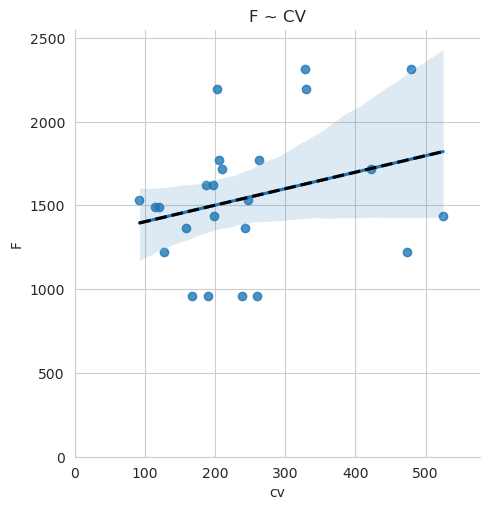

In [18]:

df = df_f_org.copy()
col = 'cv2'
max_val = np.min(np.max(df[[col, "F"]].values, axis=0))

plt.figure(figsize=(10, 6))  # Adjust figure size

# Enable grid lines
sns.set_style("whitegrid")

ax = sns.lmplot(data=df, x=col, y="F", palette="Blues")  # Customize color palette
sns.regplot(data=df, x=col, y="F", scatter_kws={'s': 5}, order=1, ci=0, ax=ax.axes[0, 0],
            x_ci=0, color="black", line_kws={"ls": "--"},scatter=False)  # Adjust scatter marker size and line style

plt.xlim(0, np.max(df[col] * 1.1))  # Adjust x-axis limits
plt.ylim(0, np.max(df["F"] * 1.1))  # Adjust y-axis limits

plt.xlabel("cv")  # Set x-axis label
plt.ylabel("F")  # Set y-axis label
plt.title("F ~ CV")  # Set plot title

plt.show()

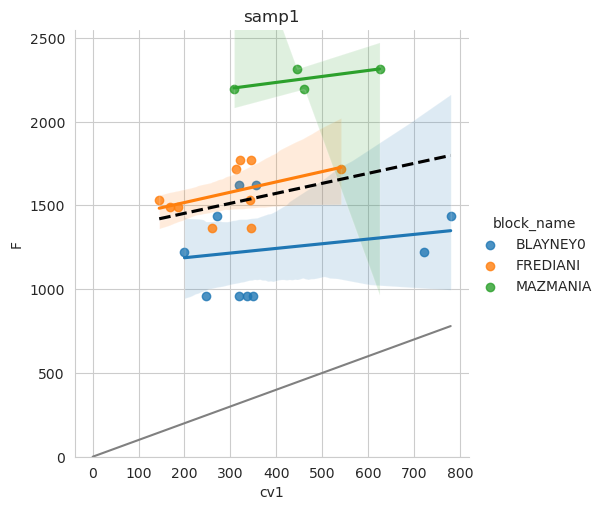

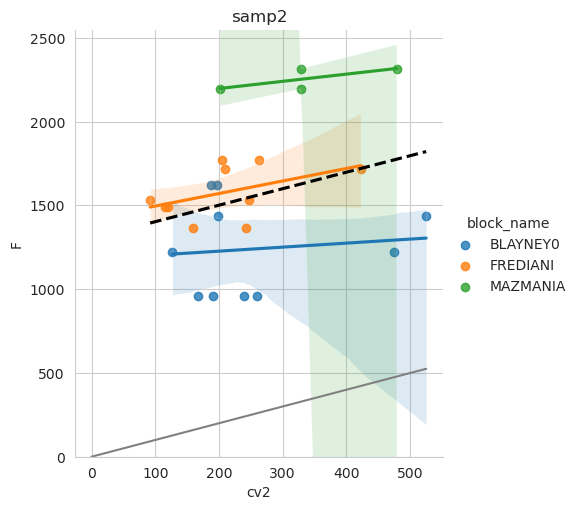

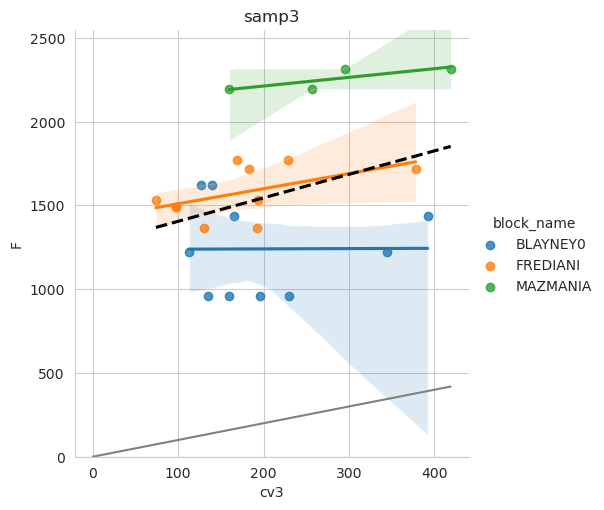

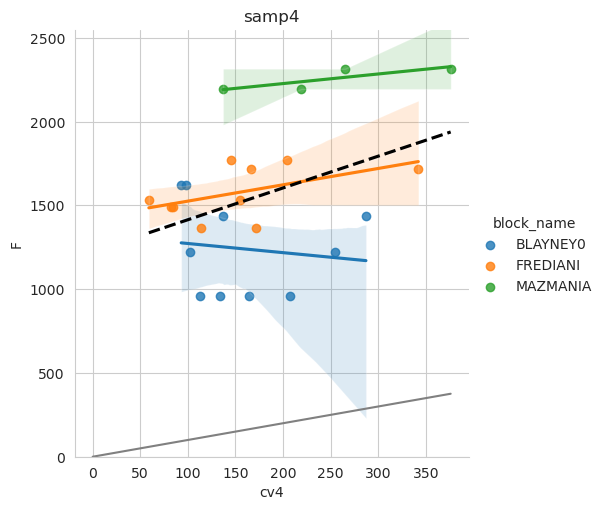

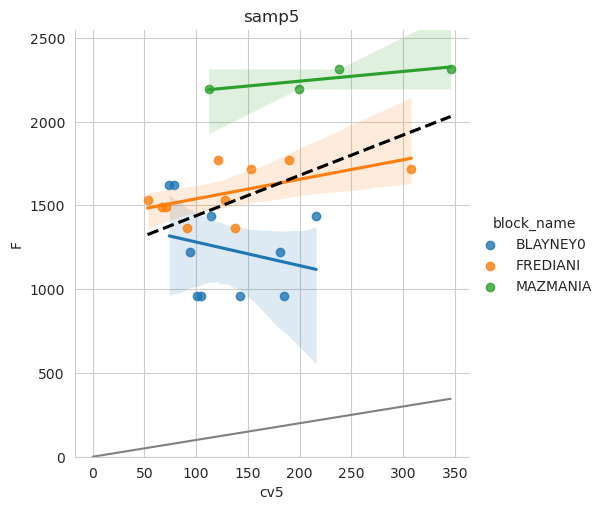

In [36]:
for i in range(1,6):
    plot_F_cv(df_f,i,"block_name", f"samp{i}")

### Exporing new features

In [20]:
df_f["cv1/cv2"] = df_f["cv1"]/df_f["cv2"]
df_f["cv2/cv3"] = df_f["cv2"]/df_f["cv3"]
df_f["cv1/cv3"] = df_f["cv1"]/df_f["cv3"]
df_f["percent_hidden1"] = (df_f["F"]-df_f["cv1"])/df_f["F"]
df_f["percent_hidden2"] = (df_f["F"]-df_f["cv2"])/df_f["F"]
df_f["percent_hidden3"] = (df_f["F"]-df_f["cv3"])/df_f["F"]

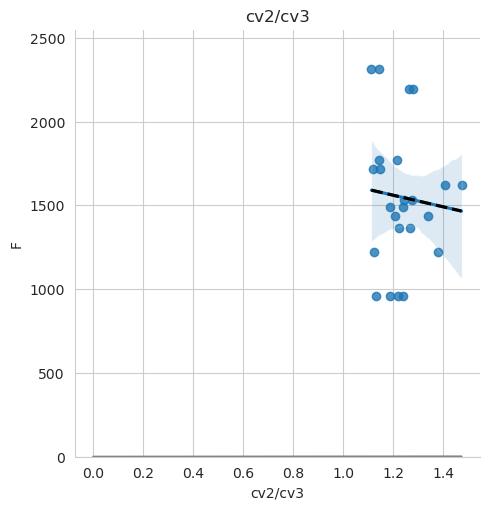

In [21]:
plot_F_cv(df_f, title= "cv2/cv3", col = "cv2/cv3")

### Modeling

In [22]:
import sys
sys.path.append(r'/home/fruitspec-lab/FruitSpec/Code/roi/fsCounter')

from MHS.scoring import cross_validate_with_mean
from sklearn.linear_model import LinearRegression, PoissonRegressor

class MaxLinearRegressor(LinearRegression):
    def __init__(self, fit_intercept=True, normalize=False, copy_X=True, n_jobs=None):
        super().__init__(fit_intercept=fit_intercept, normalize=normalize, copy_X=copy_X, n_jobs=n_jobs)
    
    def predict(self, X):
        predicted_values = super().predict(X)
        return np.array([max(p, 0) for p in predicted_values])

In [25]:
df = df_f[~df_f["cv1"].isna()].reset_index(drop = True).copy()
df["row"] = df.apply(lambda x: f'{x["block_name"]}: row{x["name"].split("_")[1]}', axis = 1)
#filter
# df = df[df["speed"] == 4].reset_index()

groups = df["block_name"]

  
X = df[["cv"]]
# X["cv2^2"] = X["cv2"]**2
y = df["F"]
model = LinearRegression(fit_intercept = False)
# model = MaxLinearRegressor(fit_intercept = False)
cross_validate_with_mean(model, X, y, groups=groups)

true: 15770.0,    pred: 9769.22154369546. (38.05 %) (FREDIANI)
true: 12408.0,    pred: 18320.321142021134. (47.65 %) (BLAYNEY0)
true: 9024.0,    pred: 6212.489157754023. (31.16 %) (MAZMANIA)
0.4319223113737802 0.11636287541806054


(0.38952351828340753, 0.06763418079737048)

In [46]:
df = df_f.reset_index(drop = True).copy()
# df = df_f[df_f["block_name"]!="FREDIANI"].reset_index(drop = True).copy()
df["row"] = df.apply(lambda x: f'{x["block_name"]}: {x["name"].split("_")[0]}', axis = 1)

from sklearn.linear_model import LinearRegression, PoissonRegressor

X = df[["cv1"]]
# X["cv2^2"] = X["cv2"]**2
y = df["F"]
model = LinearRegression(fit_intercept = True)
print(cross_validate_with_mean(model, X, y, groups=df["row"]))
print(cross_validate_with_mean(model, X, y, groups=df["block_name"]))
model.fit(X,y)
print(model.intercept_, model.coef_)

true: 6204.0,    pred: 9531.847170368777. (53.64 %) (BLAYNEY0: R5)
true: 4862.0,    pred: 4540.7893372067. (6.61 %) (FREDIANI: R3)
true: 4862.0,    pred: 4658.127561954925. (4.19 %) (FREDIANI: R2)
true: 4282.0,    pred: 4523.724297528435. (5.65 %) (BLAYNEY0: R6)
true: 4512.0,    pred: 3028.0271505467817. (32.89 %) (MAZMANIA: R2)
true: 4512.0,    pred: 2988.8073842059575. (33.76 %) (MAZMANIA: R1)
true: 3023.0,    pred: 2822.0140338191704. (6.65 %) (FREDIANI: R5)
true: 3023.0,    pred: 2963.156475973159. (1.98 %) (FREDIANI: R4)
true: 1922.0,    pred: 3183.062442204043. (65.61 %) (BLAYNEY0: R4)
0.2560757246963823 0.21799348538341584
(0.23441503996822727, 0.2260597065938742)
true: 15770.0,    pred: 14437.002793670632. (8.45 %) (FREDIANI)
true: 12408.0,    pred: 18475.95724740118. (48.90 %) (BLAYNEY0)
true: 9024.0,    pred: 5649.267612827198. (37.40 %) (MAZMANIA)
0.3394660112452175 0.18171810986945702
(0.3158454315548694, 0.17017811844609773)
1333.9636941935046 [0.59619211]


In [47]:
df = df_f.reset_index(drop = True).copy()
# df = df_f[df_f["block_name"]!="FREDIANI"].reset_index(drop = True).copy()
df["row"] = df.apply(lambda x: f'{x["block_name"]}: {x["name"].split("_")[0]}', axis = 1)

from sklearn.linear_model import LinearRegression, PoissonRegressor
for block in df["block_name"].unique():
    logic_vec = df["block_name"] == block
    X = df[logic_vec][["cv1"]].reset_index(drop = True)
    # X["cv2^2"] = X["cv2"]**2
    y = df[logic_vec]["F"].reset_index(drop = True)
    model = LinearRegression(fit_intercept = False)
    print(cross_validate_with_mean(model, X, y, groups=df[logic_vec]["row"].reset_index(drop = True)))
    model.fit(X,y)
    print(model.coef_)

true: 6204.0,    pred: 8826.420926562063. (42.27 %) (BLAYNEY0: R5)
true: 4282.0,    pred: 1745.4673105987747. (59.24 %) (BLAYNEY0: R6)
true: 1922.0,    pred: 1971.8986189063676. (2.60 %) (BLAYNEY0: R4)
0.39477650127738984 0.24866317442900082
(0.3470104149093729, 0.23734833531011343)
[3.9354004]
true: 4862.0,    pred: 4060.349898538907. (16.49 %) (FREDIANI: R3)
true: 4862.0,    pred: 6704.482635219918. (37.90 %) (FREDIANI: R2)
true: 3023.0,    pred: 1300.704428214734. (56.97 %) (FREDIANI: R5)
true: 3023.0,    pred: 2291.3419430197227. (24.20 %) (FREDIANI: R4)
0.3616246524539187 0.1382534797020882
(0.3388993686216718, 0.15374787531011422)
[6.48470194]
true: 4512.0,    pred: 6551.863493004825. (45.21 %) (MAZMANIA: R2)
true: 4512.0,    pred: 2875.129382081367. (36.28 %) (MAZMANIA: R1)
0.40615654405649376 0.039794148470682356
(0.4074395069729009, 0.04465789839164358)
[6.24413768]


In [49]:
df = df_f.reset_index(drop = True).copy()
# df = df_f[df_f["block_name"]!="FREDIANI"].reset_index(drop = True).copy()
df["row"] = df.apply(lambda x: f'{x["block_name"]}: {x["name"].split("_")[0]}', axis = 1)

from sklearn.linear_model import LinearRegression, PoissonRegressor
for block in df["block_name"].unique():
    logic_vec = df["block_name"] == block
    X = df[logic_vec][["cv1"]].reset_index(drop = True)
    # X["cv2^2"] = X["cv2"]**2
    y = df[logic_vec]["F"].reset_index(drop = True)
    model = LinearRegression(fit_intercept=True)
    print(cross_validate_with_mean(model, X, y, groups=df[logic_vec]["row"].reset_index(drop = True)))
    model.fit(X,y)
    print(model.intercept_, model.coef_)

true: 6204.0,    pred: 4866.079051383399. (21.57 %) (BLAYNEY0: R5)
true: 4282.0,    pred: 3134.5274146239262. (26.80 %) (BLAYNEY0: R6)
true: 1922.0,    pred: 2599.503261964057. (35.25 %) (BLAYNEY0: R4)
0.3373686860106508 0.057560314194034345
(0.2787098380382096, 0.056379783525653156)
1132.3498131067577 [0.27843437]
true: 4862.0,    pred: 4755.641069157793. (2.19 %) (FREDIANI: R3)
true: 4862.0,    pred: 4808.783545308104. (1.09 %) (FREDIANI: R2)
true: 3023.0,    pred: 2958.2143763793756. (2.14 %) (FREDIANI: R5)
true: 3023.0,    pred: 3121.4077502055616. (3.26 %) (FREDIANI: R4)
0.06651206503904024 0.04098084512630558
(0.02170121237679145, 0.00764121772917016)
1394.4350566459232 [0.61552577]
true: 4512.0,    pred: 4803.678832116788. (6.46 %) (MAZMANIA: R2)
true: 4512.0,    pred: 4268.341463414634. (5.40 %) (MAZMANIA: R1)
0.059237707662670704 0.005313681418246223
(0.05932373323383799, 0.0053213979977196)
2091.760536843719 [0.35723646]


In [ ]:
model.int

In [ ]:
tangos = ["OLIVER55", "BLOCK700"]
clem = ["BLAYNEY0", "FREDIANI", "MAZMANI2"]

# Tango

In [ ]:
df = df_f[df_f["block_name"].isin(tangos)].reset_index(drop = True).copy()
plot_F_cv(df,1,"block_name", f"samp{1}")
# df = df_f[df_f["block_name"]!="FREDIANI"].reset_index(drop = True).copy()
df["row"] = df.apply(lambda x: f'{x["block_name"]}: {x["name"].split("_")[0]}', axis = 1)

from sklearn.linear_model import LinearRegression, PoissonRegressor

X = df[["cv1"]]
# X["cv2^2"] = X["cv2"]**2
y = df["F"]
model = LinearRegression(fit_intercept = False)
print(cross_validate_with_mean(model, X, y, groups=df["row"]))
print(cross_validate_with_mean(model, X, y, groups=df["block_name"]))
model.fit(X,y)
model.coef_

# clem

In [ ]:
df = df_f[df_f["block_name"].isin(clem)].reset_index(drop = True).copy()
plot_F_cv(df,1,"block_name", f"samp{1}")
# df = df_f[df_f["block_name"]!="FREDIANI"].reset_index(drop = True).copy()
df["row"] = df.apply(lambda x: f'{x["block_name"]}: {x["name"].split("_")[0]}', axis = 1)

from sklearn.linear_model import LinearRegression, PoissonRegressor

X = df[["cv1"]]
# X["cv2^2"] = X["cv2"]**2
y = df["F"]
model = LinearRegression(fit_intercept = False)
print(cross_validate_with_mean(model, X, y, groups=df["row"]))
print(cross_validate_with_mean(model, X, y, groups=df["block_name"]))
model.fit(X,y)
model.coef_

In [ ]:
# from sklearn.externals import joblib

# def save_model(model, filename):
#     """
#     Save an sklearn model to a file.
    
#     Parameters:
#         model (object): The sklearn model object to be saved.
#         filename (str): The name of the file to save the model to.
#     """
#     joblib.dump(model, filename)

# def load_model(filename):
#     """
#     Load an sklearn model from a file.
    
#     Parameters:
#         filename (str): The name of the file to load the model from.
        
#     Returns:
#         object: The loaded sklearn model object.
#     """
#     return joblib.load(filename)


In [ ]:
from sklearn.base import BaseEstimator, RegressorMixin
import statsmodels.api as sm
import numpy as np

class GammaGLM(BaseEstimator, RegressorMixin):
    def __init__(self):
        self.model = None
        
    def fit(self, X, y):
        self.model = sm.GLM(y, X, family=sm.families.Gamma(link=sm.genmod.families.links.log()))
        self.results = self.model.fit()
        
    def predict(self, X):
        return self.results.predict(X)

import statsmodels.api as sm
import pandas as pd

X = df[["cv1"]]

# Add a constant column to the input features
X = sm.add_constant(X)

gamma_glm = GammaGLM()

cross_validate_with_mean(gamma_glm, X, y, groups=df["row"])

## V -shape

In [ ]:
df = df_f[~df_f["cv1"].isna()].reset_index(drop = True).copy()
df = df[~df["F_V"].isna()]
#filter
df = df[df["depth_filter"] == 5].reset_index(drop = True)
# df = df[df["speed"] == 2.5].reset_index()

groups = df["block"]

  
X = df[["cv3"]]
# X["cv2^2"] = X["cv2"]**2
y = df["F_V"]
model = LinearRegression(fit_intercept = False)
# model = MaxLinearRegressor()
y_pred = cross_validate_with_mean(model, X, y, groups=groups, ret_preds=True)
cross_validate_with_mean(model, X, y, groups=groups)

In [ ]:
cv_cols = [f"cv{i}" for i in range(1,4)]
cv_F_cols = [f"{col}/F" for col in cv_cols]
for cv_col, cv_F_col in zip(cv_cols, cv_F_cols):
    df[cv_F_col] = df[cv_col]/df["F"]

    display(df.groupby("speed")[cv_F_cols].mean())
display(df.groupby(["speed", "block"])[cv_F_cols].mean())
display(df.groupby("side")[cv_F_cols].mean())

In [ ]:
df = df_f[~df_f["cv1"].isna()].reset_index(drop = True).copy()
df = df[~df["F_V"].isna()]#filter
df = df[df["depth_filter"] == 5].reset_index()
# df = df[df["speed"] == 2.5].reset_index()

groups = df["block"]
  
X = df[["cv2"]]
# X["cv2^2"] = X["cv2"]**2
y = df["F_V"]
model = LinearRegression(fit_intercept = False)
# model = MaxLinearRegressor()
y_pred = cross_validate_with_mean(model, X, y, groups=None, ret_preds=True)
cross_validate_with_mean(model, X, y, groups=None)

In [ ]:
cv_cols = [f"cv{i}" for i in range(1,4)]
cv_F_cols = [f"{col}/F_V" for col in cv_cols]
for cv_col, cv_F_col in zip(cv_cols, cv_F_cols):
    df[cv_F_col] = df[cv_col]/df["F_V"]

display(df[cv_F_cols].mean())
display(df.groupby("speed")[cv_F_cols].mean())
display(df.groupby(["speed", "block"])[cv_F_cols].mean())
display(df.groupby("side")[cv_F_cols].mean())

## combining A+B results

need to map section to block

In [ ]:
df_comb = df_f_org.groupby(["section", "speed"]).mean()
for cv_col, cv_F_col in zip(cv_cols, cv_F_cols):
    df_comb[cv_F_col] = df_comb[cv_col]/df_comb["F"]
df_comb

In [ ]:
sections = [i[0] for i in df_comb.index]

In [ ]:
def sec_to_block(section):
    if section<=5:
        return "HC-2"
    if section<=10 or (section>=25 and section<=29):
        return "GL-2"
    if section<=15:
        return "HC-1"
    return "GL-1"
blocks = [sec_to_block(sec) for sec in sections]
df_comb["block"] = blocks

In [ ]:
df = df_comb.reset_index()
#filter
# df = df[df["speed"] == 4].reset_index()
# df = df[df["speed"] == 2.5].reset_index()

groups = df["block"]

  
X = df[["cv2", "cv3"]]
# X["cv2^2"] = X["cv2"]**2
y = df["F"]
model = LinearRegression(fit_intercept = False)
# model = MaxLinearRegressor()
y_pred = cross_validate_with_mean(model, X, y, groups=groups, ret_preds=True)
cross_validate_with_mean(model, X, y, groups=groups)